Loaded wav_test.wav at 16000Hz, duration: 400.17 seconds


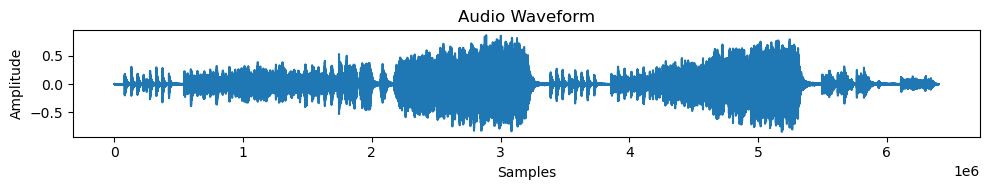

In [5]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load your own file (mono, 16kHz), or fallback to a 20s sinewave if not available
audio_path = 'wav_test.wav'  # Replace with your actual file

try:
    audio, sr = librosa.load(audio_path, sr=16000, mono=True)
    print(f"Loaded {audio_path} at {sr}Hz, duration: {len(audio)/sr:.2f} seconds")
except:
    print("No audio file found. Using synthetic 20s A4 sinewave.")
    sr = 16000
    duration = 20
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    audio = 0.5 * np.sin(2 * np.pi * 440 * t)

# Plot waveform
plt.figure(figsize=(10, 2))
plt.plot(audio)
plt.title("Audio Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [ ]:
import librosa.display

# Parameters
n_fft = 1024
hop_length = 256
n_mels = 80


# Convert audio to mel spectrogram in linear scale (power)
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)




mel_db = librosa.power_to_db(mel_spec, ref=np.max)

gap_len=0.10
start_gap = mel_db.shape[1]//2
end_gap=int(start_gap+mel_db.shape[1]*gap_len)
# Convert to dB
# Store masked version for model input
mel_db[:,start_gap:end_gap] = -80
mel_masked = mel_db.copy()

# Plot
plt.figure(figsize=(12, 6))
librosa.display.specshow(mel_masked, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title("Masked Mel Spectrogram (no -inf regions)")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()




KeyboardInterrupt: 

In [7]:
mel_db.shape

(80, 371)

In [11]:
from torch.nn import Conv2d
import torch
patchify = Conv2d(1, 128, 2, 2)
mel_db = torch.tensor(mel_db).unsqueeze(0)
mel_db.shape

torch.Size([1, 80, 371])

In [12]:
patched_mel_db = patchify(mel_db)

In [13]:
patched_mel_db.shape

torch.Size([128, 40, 185])

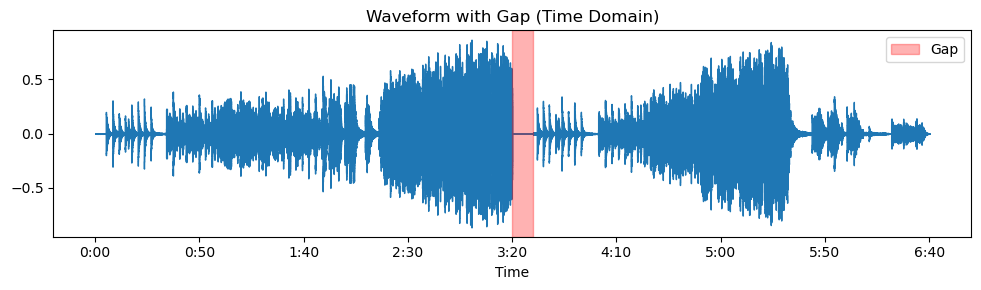

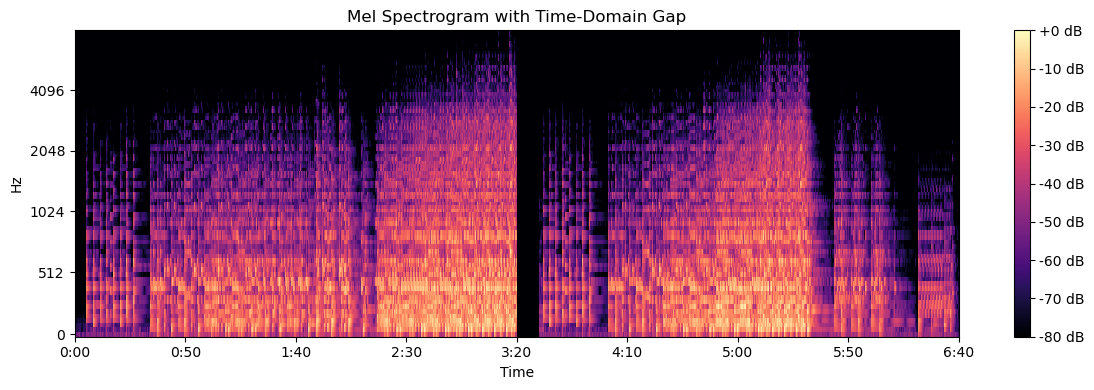

In [12]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

# --- Step 1: Load original audio ---
audio, sr = librosa.load("wav_test.wav", sr=16000)

# --- Step 2: Define gap parameters in seconds ---
gap_duration_sec = 10
gap_start_sec = len(audio) / sr / 2  # start at middle of audio
gap_start_sample = int(gap_start_sec * sr)
gap_end_sample = int(gap_start_sample + gap_duration_sec * sr)

# Clamp in case it goes out of bounds
gap_end_sample = min(gap_end_sample, len(audio))

# --- Step 3: Apply the gap by zeroing the waveform ---
audio_gapped = audio.copy()
audio_gapped[gap_start_sample:gap_end_sample] = 0.0  # silence

# --- Step 4: Save gapped audio ---
sf.write("gapped_audio.wav", audio_gapped, sr)

# --- Step 5: Visualize the waveform and Mel-spectrogram ---
plt.figure(figsize=(10, 3))
librosa.display.waveshow(audio_gapped, sr=sr)
plt.axvspan(gap_start_sample / sr, gap_end_sample / sr, color='red', alpha=0.3, label='Gap')
plt.title("Waveform with Gap (Time Domain)")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Spectrogram
mel_spec = librosa.feature.melspectrogram(y=audio_gapped, sr=sr, n_fft=1024, hop_length=256, n_mels=80)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_db, sr=sr, hop_length=256, x_axis='time', y_axis='mel')
plt.title("Mel Spectrogram with Time-Domain Gap")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()